### 이항 분류, CPU
#### 표준화를 사용: country2.csv
- 평균 -> 편차 -> 편차의 제곱의 평균(분산) -> 표준 편차 -> 표준화(z) -> 표준정규분포

In [2]:
import warnings
warnings.filterwarnings(action='ignore')

import os
import time
# import cv2
import random

import numpy as np
import pandas as pd
import seaborn as sb
import tensorflow as tf

from tensorflow.keras.models import Sequential  # class
from tensorflow.keras.models import load_model  # model 사용
from tensorflow.keras.layers import Dense       # 전결합
from tensorflow.keras.layers import Dropout     # 특정 node를 사용안함.
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten

from tensorflow.keras.callbacks import EarlyStopping   # 학습 자동 중지
from tensorflow.keras.callbacks import ModelCheckpoint # 우수한 학습 모델 파일 저장
from tensorflow.keras import regularizers 
from tensorflow.keras.utils import to_categorical   # one-hot 엔코딩
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.datasets import mnist

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split # 학습셋과 테스트셋의 분리 지원
from sklearn.model_selection import StratifiedKFold  # K겹 교차 검증

from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sb
from matplotlib import font_manager, rc

import platform 
# Windows, Linux, Darwin
if (platform.system() == 'Windows'):  
    rc('font', family=font_manager.FontProperties(fname="C:/Windows/Fonts/malgun.ttf").get_name())
    path = '.' # Local
else:    
    rc('font', family='NanumBarunGothic')  # Ubuntu 18.04 기준 한글 처리
    path = '/content/drive/My Drive/kd_ml/dnn/country' # Colab

os.chdir(path) # 기본 경로 설정

plt.rcParams["font.size"] = 12         # 글자 크기
plt.rcParams["figure.figsize"] = (6, 3) # 10:4의 그래프 비율
plt.rcParams['axes.unicode_minus'] = False  # minus 부호는 unicode 적용시 한글이 깨짐으로 설정

%matplotlib inline

# ---------------------------------------------------------------------
# gpu 사용시 런타임에서 필요한 양만큼의 GPU 메모리를 할당후 자동 증가 처리
# OS 메모리도 초기화됨.
# ---------------------------------------------------------------------
import tensorflow as tf

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # 프로그램 시작시에 메모리 증가가 설정되어야만 합니다
        print(e)
    
# ---------------------------------------------------------------------

In [3]:
# 데이터 준비
data = np.loadtxt('../../data/country/country2.csv', delimiter=',', dtype=np.float64, 
                  skiprows=1)
print(type(data))
print(data.shape)
print(data[:3])

<class 'numpy.ndarray'>
(100, 7)
[[ 0.  0.  0.  5.  1.  0.  0.]
 [ 1.  0.  1.  6.  1.  0.  1.]
 [ 1.  1.  1. 10.  1.  0.  1.]]


In [4]:
# 평균, 표준 편차의 산출시 행방향 기준이 아니라 열방향을 기준으로 산출해야함.
# 성  명  Python  Tensorflow  Analysis
# 왕눈이  90      80            90  
# 아로미  95      90            85  
# 투투    80      65            75
# Python 과목의 평균과 표준편차는 열방향으로 구해야하나, 
# 일반적인 관측치 데이터는 행방향을 가지고 있음
print(data.shape)
datat = data.T
print(datat.shape)

(100, 7)
(7, 100)


In [5]:
print(np.sqrt(1)) # 분산 1과 표준편차 1은 같음
print(np.sqrt(2)) # 분산이 2면 표준편차는 1.4142135623730951임
print(np.sqrt(4)) # 분산이 4면 표준편차는 2임

1.0
1.4142135623730951
2.0


In [6]:
print(range(len(datat)))
print(range(len(datat)-1)) # 7번째 행은 분류가 들어가 있음으로 제외

range(0, 7)
range(0, 6)


In [7]:
# 표준화, 연속실행 안됨 ★

ms = [] # 평균 목록, 테스트시 사용, 웹서비스시 사용
stds = [] # 표준편차 목록, 테스트시 사용, 웹서비스시 사용

for i in range(len(datat)-1): # 6개의 행 대상, Target 컬럼 7번째 컬럼은 제외
    # datat[i] = datat[i].astype('float32')
    m = datat[i].mean()  # 평균
    std = datat[i].std() # 표준편차
    print(i, '행 ''m:', m, ' std:', std)
    
    # 표준화 실행, 평균(m) 0, 분산 1, 표준편차: std
    datat[i] = (datat[i] - m) / std # z 값

    ms.append(m)     # 모델 사용시에 사용
    stds.append(std) # 모델 사용시에 사용

# print(datat[5])

0 행 m: 0.8  std: 1.0295630140987002
1 행 m: 0.39  std: 0.4877499359302879
2 행 m: 0.66  std: 0.4737087712930805
3 행 m: 7.32  std: 2.842111890830479
4 행 m: 0.92  std: 0.2712931993250107
5 행 m: 1.19  std: 1.2385071659057931


In [8]:
data = datat.T     # 행과열을 처음 상태로 복원
print(data.shape)
print(data[0])

(100, 7)
[-0.77702869 -0.79959006 -1.39326109 -0.81629439  0.29488391 -0.96083417
  0.        ]


In [9]:
# 데이터 분할
X = data[:, :6]
print(X[:3])
Y = data[:, 6]
print(Y[:3])

[[-0.77702869 -0.79959006 -1.39326109 -0.81629439  0.29488391 -0.96083417]
 [ 0.19425717 -0.79959006  0.71774056 -0.46444336  0.29488391 -0.96083417]
 [ 0.19425717  1.25064086  0.71774056  0.94296076  0.29488391 -0.96083417]]
[0. 1. 1.]


In [10]:
# train_test_split 분할을 통한 훈련, 검증, 테스트 데이터의 분리
# 데이터를 3그룹으로 분할: test 5% -> 95%(train 80%, validation 20%)
seed = 0
# stratify=Y: 0과 1의 분류 비율을 동일하게 데이터를 분할해줌.
# 95%: 분할대기(x_train_all), 5%: 테스트(x_test)
# x_train_all: 훈련 데이터 95% 분할 대기
# x_test: 테스트 데이터 5% 분할
# y_train_all: 훈련 target(class) 95% 분할 대기
# y_test: 테스트 target(class) 5% 분할
x_train, x_test, y_train, y_test = train_test_split(X, Y,
                                                  #  stratify=Y > training set 과 test set의 분류종류가 (즉 0, 1이) 일정하게 섞이는 기능 지원
                                                  stratify=Y,
                                                  test_size=0.1,
                                                  random_state=seed)
# 나머지 데이터 95%를 분할, 80%: 훈련(x_train), 20%: 검증(x_val)
# x_train: 훈련 데이터 80% 분할
# x_val: 검증 데이터 20% 분할
# y_train: 훈련 target(class) 80% 분할
# y_val: 검증 target(class) 20% 분할
# x_train, x_val, y_train, y_val = train_test_split(x_train_all, y_train_all,
#                                                   stratify=y_train_all,
#                                                   test_size=0.2,
#                                                   random_state=seed)
print(x_train.shape)
print(y_train.shape)
print(y_train[0:3]) # 검증 Target 3건만 출력

(90, 6)
(90,)
[0. 0. 0.]


In [12]:
import autokeras as ak

# Autokeras
SEED = 0
os.environ['PYTHONHASHSEED'] = str(SEED)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

tf.random.set_seed(SEED) # Global seed
np.random.seed(SEED)
random.seed(SEED)

# AutoKeras를 사용하여 구조화된 데이터에 대한 회귀 모델을 생성합니다.
# 사용할 옵티마이저 정의 (Adam 옵티마이저, 학습률=0.001)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.01) # 기본값 Adam, 0.001
    # optimizer=optimizer,
akmodel = ak.StructuredDataClassifier(
    max_trials=3,  # 최대 시도 횟수를 1로 설정합니다. 이는 AutoKeras가 탐색할 모델 구성의 최대 개수입니다.
    overwrite=True # 이전에 실행한 모델 훈련 세션을 덮어쓸지 여부를 결정합니다. True이면 이전 세션을 덮어씁니다.
)

import os, datetime
# 로그 디렉토리 생성: 현재 시간을 기반으로한 포맷으로 생성됨
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# TensorBoard 콜백 정의:
# - logdir: TensorBoard가 생성된 로그 파일을 저장할 디렉토리 경로
# - histogram_freq=0: 히스토그램 시각화를 얼마나 자주 기록할지를 설정합니다.
#   여기서는 0으로 설정하여 히스토그램을 기록하지 않음을 의미합니다. Autokeras는 0을 지정해야함.
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=0)

# patience=7: 손실이 7번 늘어날때까지 훈련을 계속, 7번째 종료
# restore_best_weights=True: 가중치를 가장 오차가 적었던 경우로 저장
es = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

# 모델을 훈련합니다. x_train은 입력 데이터, y_train은 타겟 데이터입니다.
#     batch_size=10,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
#     validation_split=0.2,  # 전체 훈련 데이터의 20%를 검증 데이터로 사용합니다. 이는 모델의 성능을 검증하기 위해 사용됩니다.
start = time.time()
akmodel.fit(
    x_train,
    y_train,
    epochs=50,  # 전체 훈련 데이터셋에 대해 모델을 5번 반복 훈련합니다. 기본 1000
    batch_size=1,  # 각 훈련 스텝에서 1개의 샘플을 사용합니다. 작은 배치 크기는 더 높은 메모리 사용량과 느린 훈련 속도를 유발할 수 있습니다., 기본 32
    callbacks=[tensorboard_callback, es])

end = time.time()
print('Runtime: {0:.2f} 초'.format(end-start)) # Colab: 130.44 s

Trial 3 Complete [00h 00m 07s]
val_accuracy: 0.9444444179534912

Best val_accuracy So Far: 0.9444444179534912
Total elapsed time: 00h 00m 25s
Epoch 1/50
90/90 [==============================] - 1s 1ms/step - loss: 0.5310 - accuracy: 0.7222
Epoch 2/50
90/90 [==============================] - 0s 1ms/step - loss: 0.3076 - accuracy: 0.9889
Epoch 3/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1936 - accuracy: 0.9778
Epoch 4/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1356 - accuracy: 0.9889
Epoch 5/50
90/90 [==============================] - 0s 1ms/step - loss: 0.1046 - accuracy: 0.9889
Epoch 6/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0867 - accuracy: 0.9889
Epoch 7/50
90/90 [==============================] - 0s 1ms/step - loss: 0.0753 - accuracy: 0.9889
Epoch 8/50
90/90 [==============================] - 0s 2ms/step - loss: 0.0677 - accuracy: 0.9889
Epoch 9/50
90/90 [==============================] - 0s 2ms/step - loss: 0.

In [13]:
# First we export the model to a keras model
model = akmodel.export_model()

# Now, we ask for the model Sumary:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 6)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 6)                13        
 n)                                                              
                                                                 
 dense (Dense)               (None, 32)                224       
                                                                 
 re_lu (ReLU)                (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 32)                1056  

In [17]:
from tensorflow.keras.utils import plot_model
plot_model(model)

model.save("Economic_auto_model", save_format="tf")
model = load_model("Economic_auto_model", custom_objects=ak.CUSTOM_OBJECTS)

y_test_p = model.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
INFO:tensorflow:Assets written to: Economic_auto_model\assets
1/1 [==============================] - 0s 138ms/step
<class 'numpy.ndarray'>
(10, 1)


In [18]:
# 1) 주당 음주 횟수: 0 ~ 3(3회 이상)
# 2) 농촌에서 생활적이 있다: 0(없음), 1(있음)
# 3) 가족중에 농촌에서 생활하고 있는 친척있는 여부: 0(없음), 1(있음)
# 4) 1년동안의 여행 횟수: 0 ~ 12
#     (12이상, 교통을 이용한 등산/캠핑, 당일, 국내, 국외 모두 해당)
# 5) 집을 소유 할 수 있는 경제력: 0(없음), 1(있음)
# 6) 경작 할 수 있는 토지 평수: 0 ~ (평)
#     0: 없음, 1: 1 ~ 2000 미만, 2: 2000이상 ~ 3000미만, 3: 3000 이상
# 7) 정착: 1, 실패: 0
        
drink = int(input('주당 음주 횟수는 (0 ~ 3(3회 이상)):'))
life = int(input('농촌에서 생활한 경험(0(없음), 1(있음)):'))
life2 = int(input('가족중에 농촌에서 생활하고 있는 친척있는 여부(0(없음), 1(있음)):'))
trip = int(input('1년동안의 여행 횟수(0 ~ 12):'))
house = int(input('집을 소유 할 수 있는 경제력(0(없음), 1(있음)):'))
land = int(input('경작 할 수 있는 토지 평수(0: 없음, 1: 1 ~ 2000 미만, 2: 2000이상 ~ 3000미만, 3: 3000 이상):'))

In [19]:
# 모집단의 평균과 표준편차를 이용하여 테스트 데이터의 표준화 진행 ★★★★★
data = []
data.append((drink - ms[0]) / stds[0])
data.append((life - ms[1]) / stds[1])
data.append((life2 - ms[2]) / stds[2])
data.append((trip - ms[3]) / stds[3])
data.append((house - ms[4]) / stds[4])
data.append((land - ms[5]) / stds[5])

x = np.array([
             data,
      ])
print(x.shape)
print(x)

(1, 6)
[[ 1.16554303  1.25064086  0.71774056 -1.87184749 -3.39116499 -0.96083417]]


In [20]:
yp = model.predict(x)
print(yp)
print(yp.shape)

for i in range(len(x)):
    # print('적응 확률:', yp[i][0] * 100, ' %')
    print('적응 확률: {0:.3f}%'.format(yp[i][0] * 100))
    
    if yp[i][0] >= 0.5:    # 기존 사례를 참고하여 결정
        print('시골형: 시골에 적응 할 수 있습니다.')
    else:
        print('도시형: 시골에 적응이 불가능합니다.')

1/1 [==============================] - 0s 37ms/step
[[0.88954335]]
(1, 1)
적응 확률: 88.954%
시골형: 시골에 적응 할 수 있습니다.


In [23]:
# 모든 데이터를 통으로 입력받은 경우
# 2,1,1,0,3,1,0
# 2,1,1,1,3,1,0
# 2,1,1,1,3,1,1
# 2,1,1,1,6,1,1
total = input('모든 데이터를 통으로 입력:')
total_split = np.array(total.split(','), dtype=float)
data = []
data.append((total_split[0] - ms[0]) / stds[0])
data.append((total_split[1] - ms[1]) / stds[1])
data.append((total_split[2] - ms[2]) / stds[2])
data.append((total_split[3] - ms[3]) / stds[3])
data.append((total_split[4] - ms[4]) / stds[4])
data.append((total_split[5] - ms[5]) / stds[5])

x = np.array([
             data,
      ])

yp = model.predict(x)

for i in range(len(x)):
    # print('적응 확률:', yp[i][0] * 100, ' %')
    print('적응 확률: {0:.3f}%'.format(yp[i][0] * 100))
    
    if yp[i][0] >= 0.5:    # 기존 사례를 참고하여 결정
        print('시골형: 시골에 적응 할 수 있습니다.')
    else:
        print('도시형: 시골에 적응이 불가능합니다.')

1/1 [==============================] - 0s 15ms/step
적응 확률: 88.954%
시골형: 시골에 적응 할 수 있습니다.


In [ ]:
# y = aX + b에서 데이터를 읽고 오차가 가장 작은 a, b를 찾는 과정을
# 머신러닝이라고함.
# 데이터의 규칙(패턴)을 발견하고 최적의 a, b를 찾게됨.
# 모델(a: 기울기, b: y 절편)이 발견되면 새로운 X를 대입하여 y를 예측 할 수 있음. 

# - 하나의 변수에 대한 것은 y = a1X1 + b 로 예측 가능
# - 2개이상의 변수 y = a1*X1 + a2*X2 + b 로 해결 가능
# - 3개이상의 변수 y = a1*X1 + a2*X2 + a3*X3 + b 로 해결 가능
# - 관계형 데이터베이스의 변수(컬럼)는 보통 10 ~ 20개 이상임으로 
# - 개발자가 직접 선형회귀 구현 어려움

# 선형회귀를 이용한 도시형/귀촌/귀농에 성공한 사람들의 패턴을 파악하여 고객 진단
# - 시골에 가족(친척)이 있는지 여부
# - 시골에서 생활한 경험
# - 자택 소유
# - 토지
# - 1년의 여행 횟수
# - 음주 횟수
# - 운전면허 소유 여부
# - 차량 소유 여부
# - 성격
# - 성별
# - 판정(도시형/주말 펜션/귀촌/귀농), class

# 머신러닝은 선형회귀/분류 알고리즘을 이용하여 도시형인지 시골형인지 진단
# 딥러닝 신경망(회귀)에 기반하여 도시형인지 시골형인지 진단

In [46]:
test_loss, test_acc = model.evaluate(x_test, y_test, batch_size=1, verbose=0)
print('손실값:', test_loss, '/정확도:', (test_acc*100), '%')

손실값: 0.0005887653096579015 /정확도: 100.0 %


In [28]:
model = load_model("Economic_auto_model", custom_objects=ak.CUSTOM_OBJECTS)

In [31]:
y_test_p = model.predict(x_test) # 모델 사용
print(type(y_test_p))
print(y_test_p.shape) # (146, 1): 테스트 관측치(행)는 146개임, 예측값의 수 1

1/1 [==============================] - 0s 28ms/step
<class 'numpy.ndarray'>
(10, 1)


In [33]:
for i in range(len(x_test)):
    fmt = '실제값: {0:.0f}, 예측값: {1}'

    # 임계값의 지정, 정확도를 참고하여 판단, 60%이상 합격: 0.6
    if (y_test_p[i][0] >= 0.5):
        print(' --> 호황')  # 1
    else:
        print(' --> 불황')  # 0

 --> 호황
 --> 호황
 --> 불황
 --> 호황
 --> 호황
 --> 불황
 --> 불황
 --> 불황
 --> 호황
 --> 호황


In [37]:
model.predict(x_test) >= 0.5 # True: Good, False: Bad

1/1 [==============================] - 0s 30ms/step


array([[ True],
       [ True],
       [False],
       [ True],
       [ True],
       [False],
       [False],
       [False],
       [ True],
       [ True]])

In [38]:
(model.predict(x_test) >= 0.5).astype("int32") # True: 1, False: 0

1/1 [==============================] - 0s 33ms/step


array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]])

In [39]:
# 결과 - 혼돈 행렬, # class 0우선으로 즉 오름차순으로 표가 생성
print(x_test.shape)

# 모델 테스트, Tensorflow 2.5까지 지원
# y_test_pred = model.predict_classes(x_test)

# 모델 테스트, Tensorflow 2.6 이상 지원
y_test_pred = (model.predict(x_test) >= 0.5).astype("int32")  # 모델 테스트,
print(y_test_pred[:10])

(10, 6)
1/1 [==============================] - 0s 31ms/step
[[1]
 [1]
 [0]
 [1]
 [1]
 [0]
 [0]
 [0]
 [1]
 [1]]


In [41]:
c_matrix = (y_test, y_test_pred) # 실제값, 예측값
print(type(c_matrix))
print(c_matrix)

# [[0의 갯수        0이 아닌 갯수]
#  [ 1이 아닌 갯수       1의 갯수]]

# [[white wine 맞춘 갯수   white wine 틀린 갯수]
#  [red wine 틀린 갯수     red wine 맞춘 갯수]]

<class 'tuple'>
(array([1., 1., 0., 1., 1., 0., 0., 0., 1., 1.]), array([[1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1]]))


1/1 [==============================] - 0s 25ms/step


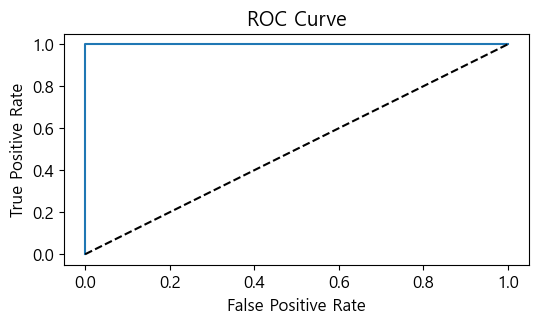

In [45]:
from sklearn.metrics import roc_curve # roc 곡

y_test_pred_probs = model.predict(x_test)
# print(y_test_pred_probs)
FPR, TPR, _ = roc_curve(y_test, y_test_pred_probs)
plt.plot(FPR, TPR)
plt.plot([0,1],[0,1],'--', color='black') #diagonal line
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()